In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from tqdm import tqdm

In [3]:
import KECENI

In [4]:
n_process = 32

In [5]:
sim_dirs = [
    'simulation_n_node_0200',
    'simulation_n_node_0400',
    'simulation_n_node_0600',
    'simulation_n_node_0800',
    'simulation_n_node_1000',
    'simulation_n_node_2000',
    'simulation_n_node_3000',
    'simulation_n_node_4000'
]

In [6]:
ns_node = np.array([200, 400, 600, 800, 1000, 2000, 3000, 4000])

In [7]:
data_dir = 'data'
save_dir = 'result'

# groundtruth

In [8]:
YTR_1, YTR_0 = (2, -2)
YTR_d = YTR_1 - YTR_0

In [9]:
YTR_1, YTR_0, YTR_d

(2, -2, 4)

# estimation

In [10]:
n_sim = 80

## - load simulation

In [11]:
YGs_0 = np.zeros((len(sim_dirs),n_sim)); YGs_1 = np.zeros((len(sim_dirs),n_sim))
YGs_d = np.zeros((len(sim_dirs),n_sim))
YDRs_0 = np.zeros((len(sim_dirs),n_sim)); YDRs_1 = np.zeros((len(sim_dirs),n_sim))
YDRs_d = np.zeros((len(sim_dirs),n_sim))

In [12]:
for i, d_i in enumerate(sim_dirs):
    for i_sim in np.arange(n_sim):
        locals().update(np.load('%s/%s/result_%.3d.npz'%(d_i,save_dir,i_sim)))
        YGs_0[i, i_sim] = YG_0; YGs_1[i, i_sim] = YG_1; YGs_d[i, i_sim] = YG_d
        YDRs_0[i, i_sim] = YDR_0[id_cv]; YDRs_1[i, i_sim] = YDR_1[id_cv]; YDRs_d[i, i_sim] = YDR_d[id_cv]

## - G estimate

In [13]:
from matplotlib import cm

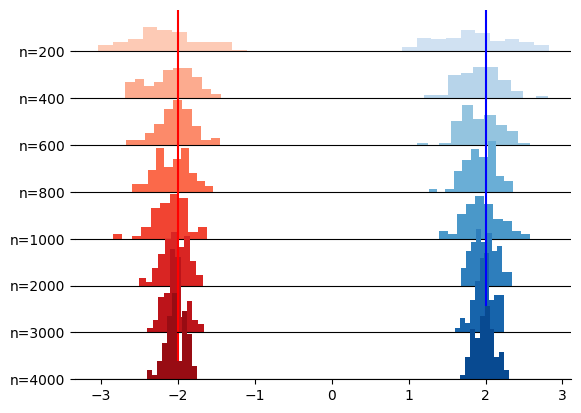

In [14]:
ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.set_yticks(-2*np.arange(len(ns_node)), ['n=%s'%n for n in ns_node])

for i, d_i in enumerate(sim_dirs):
    freq_G1, bin_G1 = np.histogram(YGs_1[i], density=True)
    plt.bar(bin_G1[:-1], freq_G1, width=np.diff(bin_G1), 
            bottom=-2*i, color=cm.Blues(0.2+0.1*i), zorder=2*i)
    # plt.axhline(y=-2*i, color=cm.Blues(0.5+0.1*i), zorder=2*i+1)
    
    freq_G2, bin_G2 = np.histogram(YGs_0[i], density=True)
    plt.bar(bin_G2[:-1], freq_G2, width=np.diff(bin_G2), 
            bottom=-2*i, color=cm.Reds(0.2+0.1*i), zorder=2*i)
    
    plt.axhline(y=-2*i, color='black', linewidth=0.8, zorder=2*i+1)
    
plt.axvline(x=YTR_1, color='blue', zorder=12)
plt.axvline(x=YTR_0, color='red', zorder=12)
    
plt.show()

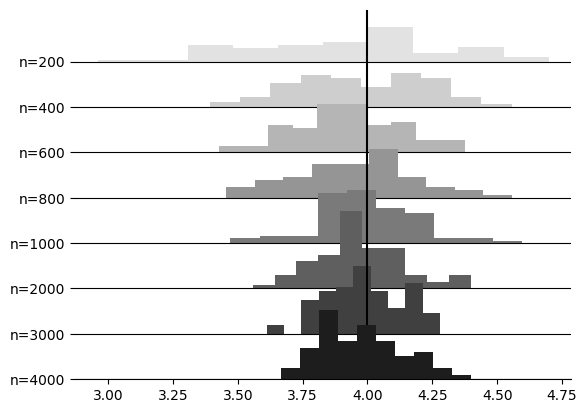

In [15]:
ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.set_yticks(-2*np.arange(len(ns_node)), ['n=%s'%n for n in ns_node])

for i, d_i in enumerate(sim_dirs):
    freq_Gd, bin_Gd = np.histogram(YGs_d[i], density=True)
    plt.bar(bin_Gd[:-1], freq_Gd, width=np.diff(bin_Gd), 
            bottom=-2*i, color=cm.Greys(0.2+0.1*i), zorder=2*i)
    
    plt.axhline(y=-2*i, color='black', linewidth=0.8, zorder=2*i+1)
    
plt.axvline(x=YTR_d, color='black', zorder=12)
    
plt.show()

<ErrorbarContainer object of 3 artists>

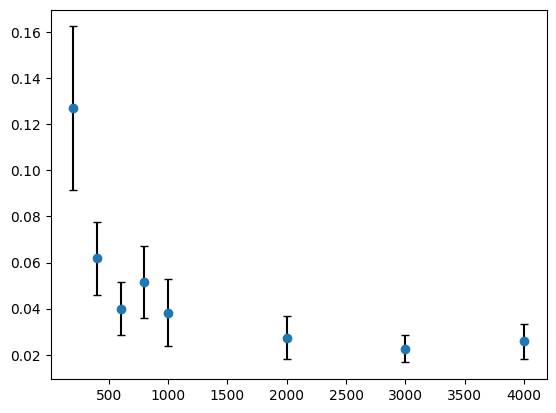

In [16]:
plt.errorbar(ns_node, np.mean((YGs_d - YTR_d)**2, -1), yerr=2*np.std((YGs_d - YTR_d)**2,-1)/np.sqrt(80), 
             ecolor='black', capsize=3, fmt="o")

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
model = LinearRegression()
model.fit(np.log(ns_node)[:,None], np.log(np.sqrt(np.mean((YGs_d - YTR_d)**2, -1))))

LinearRegression()

In [19]:
model.intercept_, model.coef_

(0.19952350225958004, array([-0.25849088]))

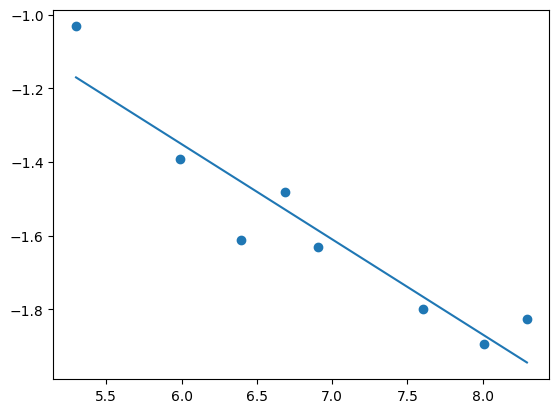

In [20]:
plt.scatter(np.log(ns_node), np.log(np.sqrt(np.mean((YGs_d - YTR_d)**2, -1))))
plt.plot(np.log(ns_node), model.predict(np.log(ns_node)[:,None]))

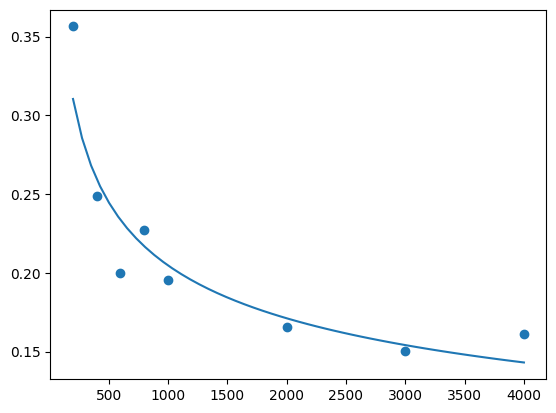

In [21]:
plt.scatter(ns_node, np.sqrt(np.mean((YGs_d - YTR_d)**2, -1)))
plt.plot(np.linspace(200, 4000, 51), np.exp(model.predict(np.log(np.linspace(200, 4000, 51))[:,None])))

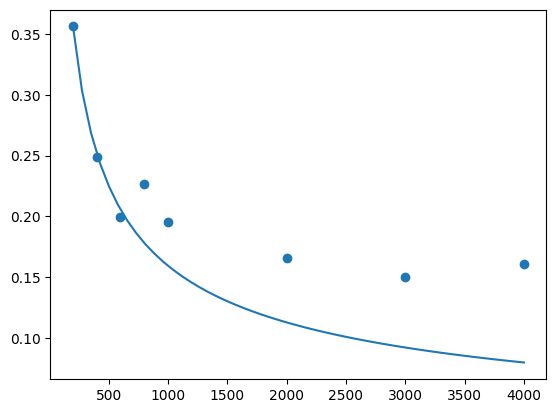

In [22]:
plt.scatter(ns_node, np.sqrt(np.mean((YGs_d - YTR_d)**2, -1)))
plt.plot(np.linspace(200, 4000, 51), 
         np.sqrt(np.mean((YGs_d - YTR_d)**2, -1))[0] * np.sqrt(ns_node[0])
         / np.sqrt(np.linspace(200, 4000, 51)))

## - KECENI

In [23]:
from matplotlib import cm

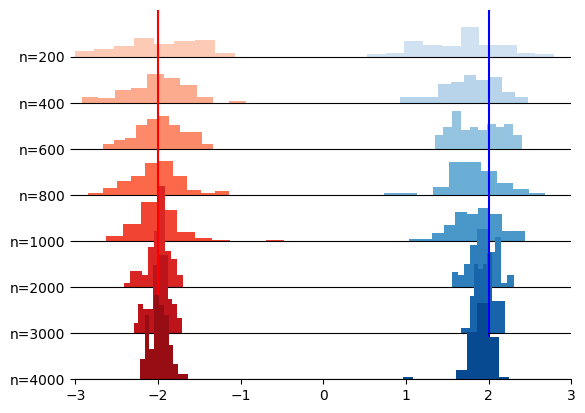

In [24]:
ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.set_yticks(-2*np.arange(len(ns_node)), ['n=%s'%n for n in ns_node])

for i, d_i in enumerate(sim_dirs):
    freq_DR1, bin_DR1 = np.histogram(YDRs_1[i], density=True)
    plt.bar(bin_DR1[:-1], freq_DR1, width=np.diff(bin_DR1), 
            bottom=-2*i, color=cm.Blues(0.2+0.1*i), zorder=2*i)
    # plt.axhline(y=-2*i, color=cm.Blues(0.5+0.1*i), zorder=2*i+1)
    
    freq_DR2, bin_DR2 = np.histogram(YDRs_0[i], density=True)
    plt.bar(bin_DR2[:-1], freq_DR2, width=np.diff(bin_DR2), 
            bottom=-2*i, color=cm.Reds(0.2+0.1*i), zorder=2*i)
    
    plt.axhline(y=-2*i, color='black', linewidth=0.8, zorder=2*i+1)
    
plt.axvline(x=YTR_1, color='blue', zorder=12)
plt.axvline(x=YTR_0, color='red', zorder=12)
plt.xlim(-3, 3)
    
plt.show()

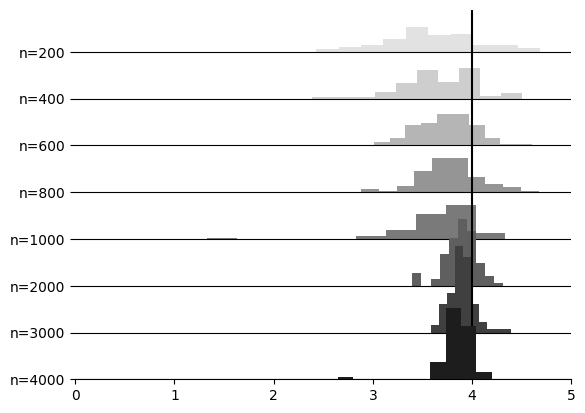

In [25]:
ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.set_yticks(-2*np.arange(len(ns_node)), ['n=%s'%n for n in ns_node])

for i, d_i in enumerate(sim_dirs):
    freq_DRd, bin_DRd = np.histogram(YDRs_d[i], density=True)
    plt.bar(bin_DRd[:-1], freq_DRd, width=np.diff(bin_DRd), 
            bottom=-2*i, color=cm.Greys(0.2+0.1*i), zorder=2*i)
    
    plt.axhline(y=-2*i, color='black', linewidth=0.8, zorder=2*i+1)
    
plt.axvline(x=YTR_d, color='black', zorder=12)
plt.xlim(0, 5)
    
plt.show()

In [ ]:
SEs = (YDRs_d - YTR_d)**2
medSE = np.median(SEs, -1)

In [ ]:
n_bst = 1000

In [ ]:
idx = np.random.choice(SEs.shape[1], size=(n_bst, SEs.shape[1]), replace=True)

In [38]:
np.quantile(np.sqrt(np.median(SEs[:,idx], -1)), (0.025, 0.975), axis=-1)

array([[0.32983262, 0.20638044, 0.17028922, 0.17919301, 0.13680443,
        0.07177681, 0.07673479, 0.06118699],
       [0.46091895, 0.34562766, 0.29839356, 0.27738623, 0.24754374,
        0.12642614, 0.11681516, 0.10345914]])

<ErrorbarContainer object of 3 artists>

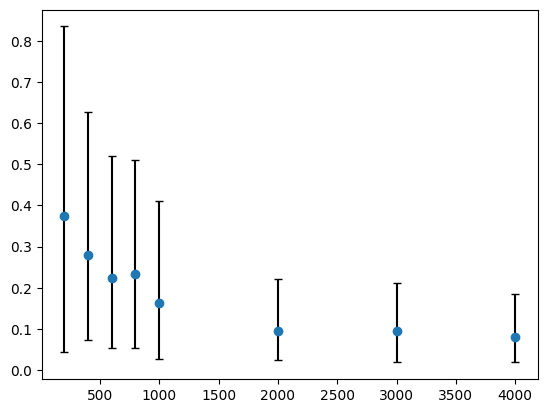

In [39]:
plt.errorbar(ns_node, np.sqrt(np.median(SEs, -1)), 
             yerr=np.quantile(np.sqrt(np.median(SEs[:,idx], -1)), (0.025, 0.975), axis=-1),
             ecolor='black', capsize=3, fmt="o")

In [26]:
from sklearn.linear_model import LinearRegression

In [40]:
model = LinearRegression()
model.fit(np.log(ns_node)[:,None], np.log(np.sqrt(np.median((YDRs_d - YTR_d)**2, -1))))

LinearRegression()

In [41]:
model.intercept_, model.coef_

(1.976899123165904, array([-0.54464096]))

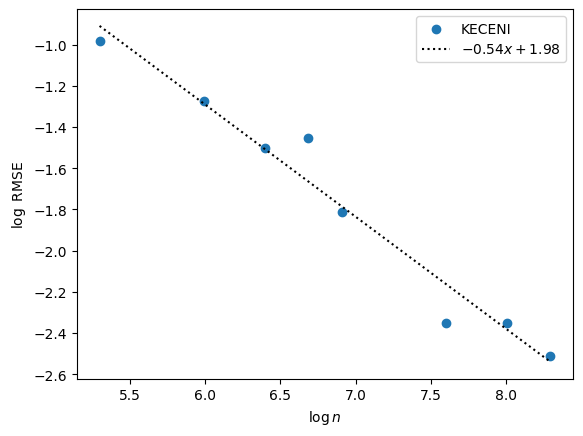

In [44]:
plt.scatter(np.log(ns_node), np.log(np.sqrt(np.median((YDRs_d - YTR_d)**2, -1))), label='KECENI')
# plt.plot(np.log(ns_node), np.log(np.sqrt(np.mean((YGds - YTRd)**2, -1)))
#         - np.log(np.sqrt(np.mean((YGds - YTRd)**2, -1)))[0])
plt.plot(np.log(ns_node), model.predict(np.log(ns_node)[:,None]), 
         color='black', linestyle=':', label=r'$-0.54 x + 1.98$')
plt.xlabel(r'$\log n$'); plt.ylabel(r'$\log$ RMSE')
plt.legend()

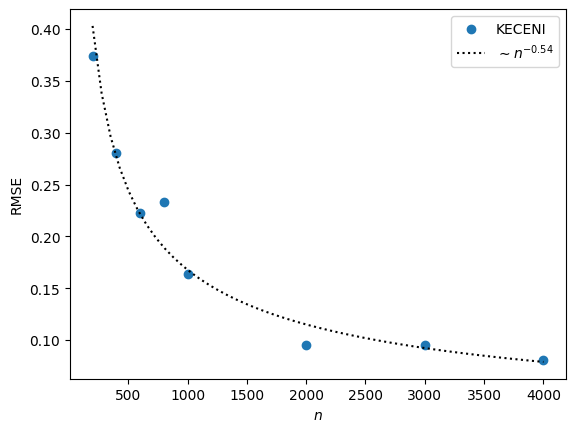

In [47]:
plt.scatter(ns_node, np.sqrt(np.median((YDRs_d - YTR_d)**2, -1)), label='KECENI')
plt.plot(np.linspace(200, 4000, 51), np.exp(model.predict(np.log(np.linspace(200, 4000, 51))[:,None])),
         color='black', linestyle=':', label=r'$\sim n^{-0.54}$')
plt.xlabel(r'$n$'); plt.ylabel('RMSE')
plt.legend()